# Multiclass Classification with PyCaret Tutorial
In this tutorial we will learn:

- **Getting Data**: How to import data from PyCaret repository
- **Setting up Environment**: How to setup an experiment in PyCaret and get started with building multiclass models
- **Create Model**: How to create a model, perform stratified cross validation and evaluate classification metrics
-  **Tune Model**: How to automatically tune the hyper-parameters of a multiclass model
-  **Plot Model**: How to analyze model performance using various plots
-  **Finalize Model**: How to finalize the best model at the end of the experiment
-  **Predict Model**: How to make predictions on new / unseen data
-  **Save / Load Model**: How to save / load a model for future use


In [ ]:
!pip install pycaret

### For Google colab users

In [2]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


### What is Multiclass Classification?
Multiclass classification is a supervised machine learning technique where the goal is to classify instances into one of three or more classes. (Classifying instances into one of two classes is called Binary Classification). Multiclass classification should not be confused with multi-label classification, where multiple labels are to be predicted for each instance.

### Dataset for the Tutorial
For this tutorial we will use the **Iris Dataset** from UCI. This is perhaps the best known database to be found in the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. Short descriptions of each column are as follows:

- **sepal_length**: Length of Sepal
- **sepal_width**: Width of Sepal
- **petal_length**: Length of Petal
- **petal_width**: Width of Petal
- **species**: One of three class (Setosa, Versicolour, Virginica) Target Column

Dataset Acknowledgement:

Creator: R.A. Fisher, Donor : Michael Marshall (MARSHALL%PLU '@' io.arc.nasa.gov)

The original dataset and data dictionary can be [found here](https://archive.ics.uci.edu/ml/datasets/Iris).

### Getting the Data


You can download the data from the original source found here and load it using pandas or you can use PyCaret's data respository to load the data using the get_data() function.


In [3]:
from pycaret.datasets import get_data
dataset = get_data('iris')

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
#check the shape of data
dataset.shape

(150, 5)

In order to demonstrate the predict_model() function on unseen data, a sample of 15 records has been withheld from the original dataset to be used for predictions. This should not be confused with a train/test split as this particular split is performed to simulate a real life scenario. Another way to think about this is that these 15 records were not available at the time when the machine learning experiment was performed.

In [5]:
data = dataset.sample(frac=0.9, random_state=786)
data_unseen = dataset.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (135, 5)
Unseen Data For Predictions: (15, 5)


## Setting up the Environment in PyCaret

The setup() function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. **setup() must be called before executing any other function in pycaret**. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional and are used to customize the pre-processing pipeline.

When setup() is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after setup() is executed. If all of the data types are correctly identified enter can be pressed to continue or quit can be typed to end the expriment. Ensuring that the data types are correct is of fundamental importance in PyCaret as it automatically performs a few pre-processing tasks which are imperative to any machine learning experiment. These tasks are performed differently for each data type which means it is very important for them to be correctly configured.


In [6]:
from pycaret.classification import *
exp_mclf101 = setup(data = data, target = 'species', session_id=123)

,Description,Value
0,session_id,123
1,Target,species
2,Target Type,Multiclass
3,Label Encoded,"Iris-setosa: 0, Iris-versicolor: 1, Iris-virgi..."
4,Original Data,"(135, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


Once the setup has been succesfully executed it prints the information grid which contains several important pieces of information. Most of the information is related to the pre-processing pipeline which is constructed when setup() is executed. A few important things to note at this stage include:

- **session_id**: A pseduo-random number distributed as a seed in all functions for later reproducibility. If no session_id is passed, a random number is automatically generated that is distributed to all functions. In this experiment, the session_id is set as 123 for later reproducibility.

- **Target Type**: Binary or Multiclass. The Target type is automatically detected and shown. There is no difference in how the experiment is performed for Binary or Multiclass problems. All functionalities are identical.

- **Label Encoded**: When the Target variable is of type string (i.e. 'Yes' or 'No') instead of 1 or 0, it automatically encodes the label into 1 and 0 and displays the mapping (0 : No, 1 : Yes) for reference. In this experiment label encoding is applied as follows: Iris-setosa: 0, Iris-versicolor: 1, Iris-virginica: 2.

- **Original Data**: Displays the original shape of the dataset. In this experiment (135, 5) means 135 samples and 5 features including the target column.

- **Missing Values**: When there are missing values in the original data this will show as True. For this experiment there are no missing values in the dataset.

- **Numeric Features**: The number of features inferred as numeric. In this dataset, 4 out of 5 features are inferred as numeric.

- **Categorical Features**: The number of features inferred as categorical. In this dataset, there are no categorical features.

- **Transformed Train Set**: Displays the shape of the transformed training set. Notice that the original shape of (135, 5) is transformed into (94, 4) for the transformed train set.

- **Transformed Test Set**: Displays the shape of the transformed test/hold-out set. There are 41 samples in test/hold-out set. This split is based on the default value of 70/30 that can be changed using the train_size parameter in setup.

Notice how a few tasks that are imperative to perform modeling are automatically handled such as missing value imputation, categorical encoding etc. Most of the parameters in setup() are optional and used for customizing the pre-processing pipeline.


### Comparing All Models
Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case). This function trains all models in the model library and scores them using stratified cross validation for metric evaluation. The output prints a score grid that shows average Accuracy, Recall, Precision, F1, Kappa, and MCC accross the folds (10 by default) along with training times.

In [7]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9678,0.9963,0.9667,0.9758,0.9669,0.9515,0.9560,0.017
nb,Naive Bayes,0.9578,0.9897,0.9556,0.9713,0.9546,0.9364,0.9442,0.017
qda,Quadratic Discriminant Analysis,0.9567,1.0000,0.9556,0.9708,0.9533,0.9348,0.9433,0.018
lr,Logistic Regression,0.9478,0.9963,0.9444,0.9638,0.9444,0.9212,0.9304,0.302
knn,K Neighbors Classifier,0.9467,0.9926,0.9444,0.9630,0.9432,0.9197,0.9291,0.115
lightgbm,Light Gradient Boosting Machine,0.9456,0.9852,0.9444,0.9625,0.9419,0.9182,0.9282,0.040
ada,Ada Boost Classifier,0.9256,0.9809,0.9222,0.9505,0.9194,0.8879,0.9026,0.095
gbc,Gradient Boosting Classifier,0.9256,0.9815,0.9222,0.9505,0.9194,0.8879,0.9026,0.194
et,Extra Trees Classifier,0.9256,0.9926,0.9222,0.9505,0.9194,0.8879,0.9026,0.432
dt,Decision Tree Classifier,0.9144,0.9369,0.9111,0.9366,0.9086,0.8712,0.8843,0.018


The score grid printed above highlights the highest performing metric for comparison purposes only. The grid by default is sorted using 'Accuracy' (highest to lowest) which can be changed by passing the sort parameter. For example compare_models(sort = 'Recall') will sort the grid by Recall instead of Accuracy. If you want to change the fold parameter from the default value of 10 to a different value then you can use the fold parameter. For example compare_models(fold = 5) will compare all models on 5 fold cross validation. Reducing the number of folds will improve the training time. By default, compare_models return the best performing model based on default sort order but can be used to return a list of top N models by using n_select parameter.

**Note**: The AUC metric is not available for Multiclass classification however the column will still be shown with zero values to maintain consistency between the Binary Classification and Multiclass Classification display grids.

### Create a Model


create_model is the most granular function in PyCaret and is often the foundation behind most of the PyCaret functionalities. As the name suggests this function trains and evaluates a model using cross validation that can be set with fold parameter. The output prints a score grid that shows Accuracy, Recall, Precision, F1, Kappa and MCC by fold.

For the remaining part of this tutorial, we will work with the below models as our candidate models. The selections are for illustration purposes only and do not necessarily mean they are the top performing or ideal for this type of data.

- Decision Tree Classifier ('dt')
- K Neighbors Classifier ('knn')
- Logistic Regression ('lr')

There are 18 classifiers available in the model library of PyCaret. Please view the create_model() docstring for the list of all available models.


#### Decision Tree Classifier

In [9]:
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9000,0.9286,0.8889,0.9250,0.8971,0.8485,0.8616
3,0.8000,0.8571,0.7778,0.8800,0.7750,0.6970,0.7435
4,0.7778,0.8333,0.7778,0.7778,0.7778,0.6667,0.6667
5,0.7778,0.8333,0.7778,0.8667,0.7500,0.6667,0.7223
6,0.8889,0.9167,0.8889,0.9167,0.8857,0.8333,0.8492
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [10]:
#trained model object is stored in the variable 'dt'. 
print(dt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')


#### K Neighbors Classifier

In [11]:
knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.8000,1.0000,0.7778,0.8800,0.7750,0.6970,0.7435
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.8889,0.9630,0.8889,0.9167,0.8857,0.8333,0.8492
5,0.8889,0.9815,0.8889,0.9167,0.8857,0.8333,0.8492
6,0.8889,0.9815,0.8889,0.9167,0.8857,0.8333,0.8492
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


#### Logistic Regression

In [12]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9000,1.0000,0.8889,0.9250,0.8971,0.8485,0.8616
3,0.8000,1.0000,0.7778,0.8800,0.7750,0.6970,0.7435
4,0.8889,0.9630,0.8889,0.9167,0.8857,0.8333,0.8492
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.8889,1.0000,0.8889,0.9167,0.8857,0.8333,0.8492
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Notice that the Mean score of all models matches with the score printed in compare_models(). This is because the metrics printed in the compare_models() score grid are the average scores across all CV folds. Similar to compare_models(), if you want to change the fold parameter from the default value of 10 to a different value then you can use the fold parameter. For Example: create_model('dt', fold = 5) will create a Decision Tree Classifier using 5 fold stratified CV.

### Tune a Model

When a model is created using the create_model() function it uses the default hyperparameters to train the model. In order to tune hyperparameters, the tune_model() function is used. This function automatically tunes the hyperparameters of a model using Random Grid Search on a pre-defined search space. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1, Kappa, and MCC by fold for the best model. To use the custom search grid, you can pass custom_grid parameter in the tune_model function (see KNN tuning below).

In [13]:
tuned_dt = tune_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.8000,0.9143,0.7778,0.8800,0.7750,0.6970,0.7435
4,0.8889,0.9444,0.8889,0.9167,0.8857,0.8333,0.8492
5,0.7778,0.8611,0.7778,0.7778,0.7778,0.6667,0.6667
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [14]:
#tuned model object is stored in the variable 'tuned_dt'. 
print(tuned_dt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.2, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')


In [15]:
import numpy as np
tuned_knn = tune_model(knn, custom_grid = {'n_neighbors' : np.arange(0,50,1)})

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.8000,1.0000,0.7778,0.8800,0.7750,0.6970,0.7435
3,0.9000,0.9714,0.8889,0.9250,0.8971,0.8485,0.8616
4,0.8889,0.9259,0.8889,0.9167,0.8857,0.8333,0.8492
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.8889,1.0000,0.8889,0.9167,0.8857,0.8333,0.8492
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [16]:
tuned_lr = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9000,1.0,0.8889,0.9250,0.8971,0.8485,0.8616
3,0.8000,1.0,0.7778,0.8800,0.7750,0.6970,0.7435
4,0.8889,1.0,0.8889,0.9167,0.8857,0.8333,0.8492
5,1.0000,1.0,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.8889,1.0,0.8889,0.9167,0.8857,0.8333,0.8492
7,1.0000,1.0,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0,1.0000,1.0000,1.0000,1.0000,1.0000


The tune_model() function is a random grid search of hyperparameters over a pre-defined search space. By default, it is set to optimize Accuracy but this can be changed using the optimize parameter. For example: tune_model(dt, optimize = 'Recall') will search for the hyperparameters of a Decision Tree Classifier that result in the highest Recall. For the purposes of this example, we have used the default metric Accuracy for the sake of simplicity only. 

Metrics alone are not the only criteria you should consider when finalizing the best model for production. Other factors to consider include training time, standard deviation of kfolds etc. Let's move forward considering the Tuned K Neighbors Classifier as our best model for the remainder of this tutorial.

### Plot a Model
Before model finalization, the plot_model() function can be used to analyze the performance across different aspects such as AUC, confusion_matrix, decision boundary etc. This function takes a trained model object and returns a plot based on the test / hold-out set.



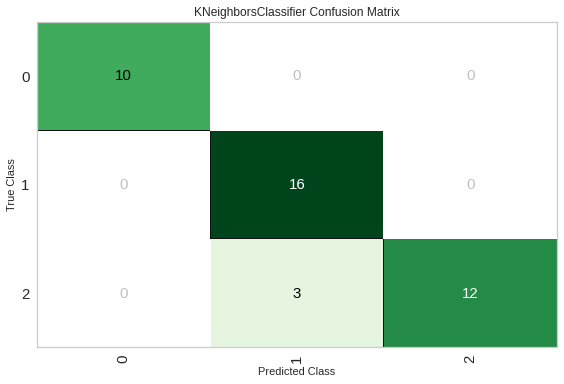

In [17]:
plot_model(tuned_knn, plot = 'confusion_matrix')

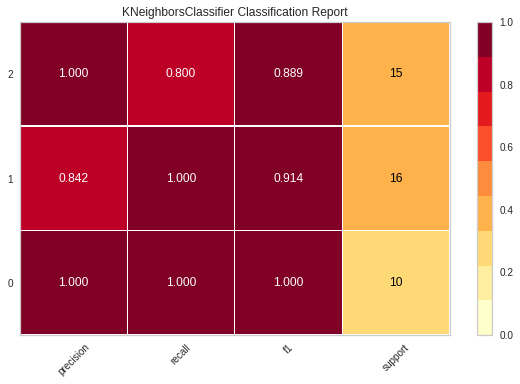

In [18]:
plot_model(tuned_knn, plot = 'class_report')

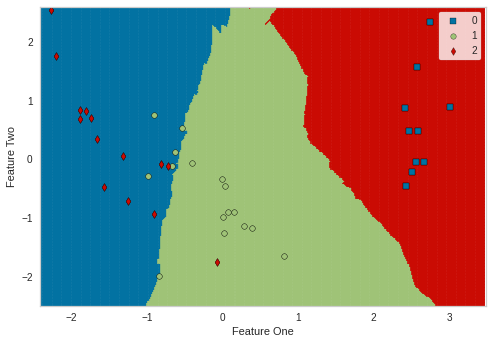

In [19]:
plot_model(tuned_knn, plot='boundary')

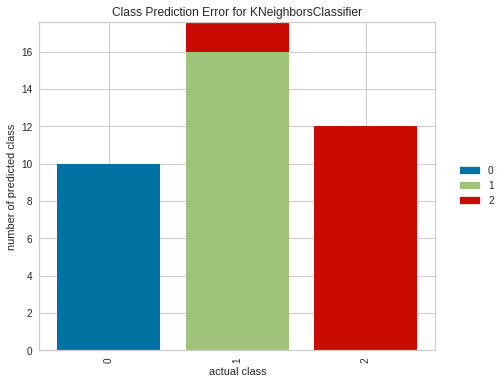

In [21]:
plot_model(tuned_knn, plot = 'error')

Another way to analyze the performance of models is to use the evaluate_model() function which displays a user interface for all of the available plots for a given model. It internally uses the plot_model() function.

In [22]:
evaluate_model(tuned_knn)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Predict on test / hold-out Sample
Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. If you look at the information grid above, you will see that 30% (41 samples) of the data has been separated out as a test/hold-out sample. All of the evaluation metrics we have seen above are cross validated results based on the training set (70%) only. Now, using our final trained model stored in the tuned_knn variable we will predict against the hold-out sample and evaluate the metrics to see if they are materially different than the CV results.


In [23]:
predict_model(tuned_knn);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9268,0.9761,0.9333,0.9384,0.9259,0.8879,0.8953




The accuracy on the test/hold-out set is 0.9512 compared to 0.9356 achieved on the tuned_knn CV results (in section 9.2 above). This is not a significant difference. If there is a large variation between the test/hold-out and CV results, then this would normally indicate over-fitting but could also be due to several other factors and would require further investigation. In this case, we will move forward with finalizing the model and predicting on unseen data (the 10% that we had separated in the beginning and never exposed to PyCaret).

### Finalize Model for Deployment
Model finalization is the **last step** in the experiment. A normal machine learning workflow in PyCaret starts with setup(), followed by comparing all models using compare_models() and shortlisting a few candidate models (based on the metric of interest) to perform several modeling techniques such as hyperparameter tuning, ensembling, stacking etc. This workflow will eventually lead you to the best model for use in making predictions on new and unseen data. *The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case).* The purpose of this function is to train the model on the complete dataset before it is deployed in production.


In [24]:
final_knn = finalize_model(tuned_knn)

In [25]:
#Final K Nearest Neighbour parameters for deployment
print(final_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=33, p=2,
                     weights='uniform')


### Predict on unseen data
The predict_model() function is also used to predict on the unseen dataset. The only difference from section above is that this time we will pass the data_unseen parameter. data_unseen is the variable created at the beginning of the tutorial and contains 10% (15 samples) of the original dataset which was never exposed to PyCaret. 


In [26]:
unseen_predictions = predict_model(final_knn, data=data_unseen)
unseen_predictions.head()

,sepal_length,sepal_width,petal_length,petal_width,species,Label,Score
0,5.4,3.9,1.7,0.4,Iris-setosa,Iris-setosa,1.0000
1,5.4,3.4,1.7,0.2,Iris-setosa,Iris-setosa,1.0000
2,5.1,3.3,1.7,0.5,Iris-setosa,Iris-setosa,1.0000
3,4.8,3.1,1.6,0.2,Iris-setosa,Iris-setosa,1.0000
4,6.9,3.1,4.9,1.5,Iris-versicolor,Iris-versicolor,0.5455


The Label and Score columns are added onto the data_unseen set. Label is the prediction and score is the probability of the prediction. Notice that predicted results are concatenated to the original dataset while all the transformations are automatically performed in the background.

### Saving the model
We have now finished the experiment by finalizing the tuned_knn model which is now stored in the final_knn variable. We have also used the model stored in final_knn to predict data_unseen. This brings us to the end of our experiment, but one question is still to be asked: What happens when you have more new data to predict? Do you have to go through the entire experiment again? The answer is no, PyCaret's inbuilt function save_model() allows you to save the model along with entire transformation pipeline for later use.


In [27]:
save_model(final_knn,'Final KNN Model 07Mar2021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='species',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                 ('fix_perfect', Remove_100(target='species')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
        

### Loading the saved model
To load a saved model at a future date in the same or an alternative environment, we would use PyCaret's load_model() function and then easily apply the saved model on new unseen data for prediction.

In [28]:
saved_final_knn = load_model('Final KNN Model 07Mar2021')

Transformation Pipeline and Model Successfully Loaded


Once the model is loaded in the environment, you can simply use it to predict on any new data using the same predict_model() function. Below we have applied the loaded model to predict the same data_unseen that we used in section 13 above.

In [29]:
new_prediction = predict_model(saved_final_knn, data=data_unseen)

In [30]:
new_prediction.head()

,sepal_length,sepal_width,petal_length,petal_width,species,Label,Score
0,5.4,3.9,1.7,0.4,Iris-setosa,Iris-setosa,1.0000
1,5.4,3.4,1.7,0.2,Iris-setosa,Iris-setosa,1.0000
2,5.1,3.3,1.7,0.5,Iris-setosa,Iris-setosa,1.0000
3,4.8,3.1,1.6,0.2,Iris-setosa,Iris-setosa,1.0000
4,6.9,3.1,4.9,1.5,Iris-versicolor,Iris-versicolor,0.5455
